# Logistic Regression

## Visualizing the data

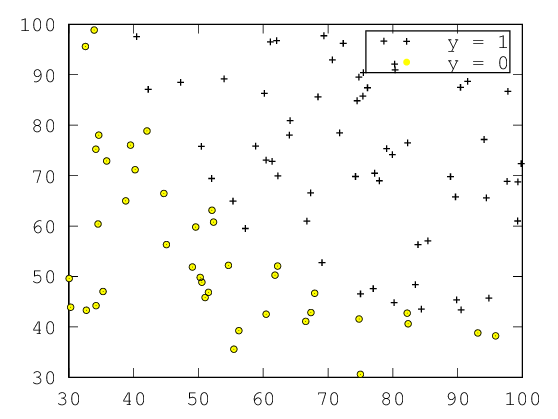

In [1]:
data = load('ex2data1.txt');
X = data(:, [1, 2]); y = data(:, 3);
plotData(X, y);

### sigmoid function

$$
\begin{eqnarray}
h_\theta(x)  & = & g(\theta^Tx)  \\
g(z) & = & {1 \over 1 + e^{-z}}
\end{eqnarray}
$$

ans =  0.50000


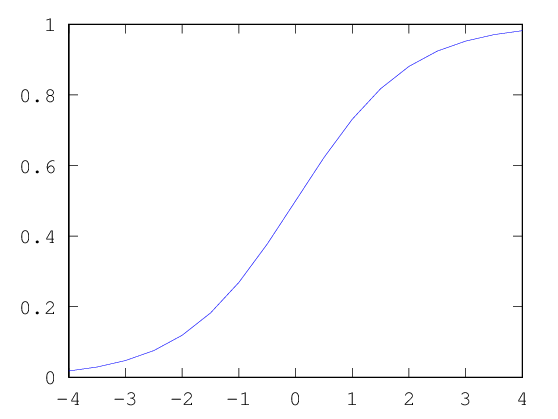

In [2]:
function g = sigmoid(z)
    es = ones(size(z)) * e;
    g = (es .^ (z * -1) + 1) .^ (-1);
endfunction

sigmoid(0)

x = -4:0.5:4;
y = sigmoid(x);
plot(x, y);

### Cost function

$$
J(\theta) = -{1 \over m}\sum_{i = 1}^m[
    y^{(i)}log(h_\theta(x^{(i)}))
    + (1 - y^{(i)})log(1 - h_\theta(x^{(i)}))
]
$$

### Gradient

$$
{\partial J(\theta) \over \partial \theta_j}
 = {1 \over m}\sum_{i = 1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
$$

In [3]:
function [J, grad] = costFunction(theta, X, y)
    m = length(y);
    J = 0;
    grad = zeros(size(theta));
    
    for i = 1:m,
        g = sigmoid(theta' * X(i, :)');

        % compute cost
        J = J + (y(i) * log(g) + (1 - y(i)) * log(1 - g));
        % compute gradient
        grad = grad + X(i, :)' * (g - y(i));
    end;
    
    J = -1 * J / m;
    grad = grad / m;
endfunction

X = data(:, [1, 2]); y = data(:, 3);
[m, n] = size(X);

X = [ones(m, 1), X];
initial_theta = zeros(n + 1, 1);
[cost, grad] = costFunction(initial_theta, X, y)

cost =  0.69315
grad =

   -0.10000
  -12.00922
  -11.26284



### Learning parameters

ロジスティック回帰における最適なパラメータ $\theta$ を選択するのに Octave のビルトイン関数である　`fminunc` を使う。

In [4]:
options = optimset('GradObj', 'on', 'MaxIter', 400);
[theta, cost] = fminunc(@(t)(costFunction(t, X, y)), 
                                            initial_theta, options)

theta =

  -25.16127
    0.20623
    0.20147

cost =  0.20350


### Decision boundary

決定境界

$$
h_\theta(x) = g(\theta_0 + \theta_1x_1 + \theta_2x_2)
$$

としたとき $\theta_0 + \theta_1x_1 + \theta_2x_2 \ge 0$ ならば $y = 1$

つまり以下が決定境界

$$
\theta_0 + \theta_1x_1 + \theta_2x_2 = 0
$$

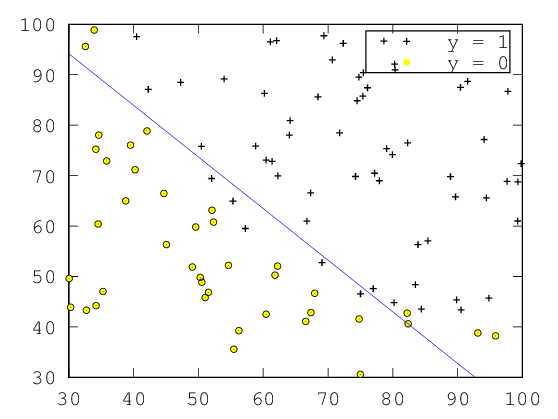

In [16]:
plotDecisionBoundary(theta, X, y);

A student with an Exam 1 score of **45** and an Exam 2 score of **85**

In [17]:
sigmoid([1, 45, 85] * theta)

ans =  0.77629


$\theta$ と $X$ から結果を予想(y = 0 or 1) する

In [18]:
function p = predict(theta, X)
    m = size(X, 1);
    p = zeros(m, 1);
    
    for i = 1:m,
        g = sigmoid(X(i, :) * theta);
        if g >= 0.5,
            p(i) = 1;
        else
            p(i) = 0;
        end;
    end;
endfunction

学習結果の正確性

In [21]:
X = data(:, [1, 2]); y = data(:, 3);
X = [ones(m, 1), X];
p = predict(theta, X);
fprintf('Train Accuracy: %f\n', mean(double(p == y)) * 100);

Train Accuracy: 89.000000


決定境界と予測が外れたデータの可視化

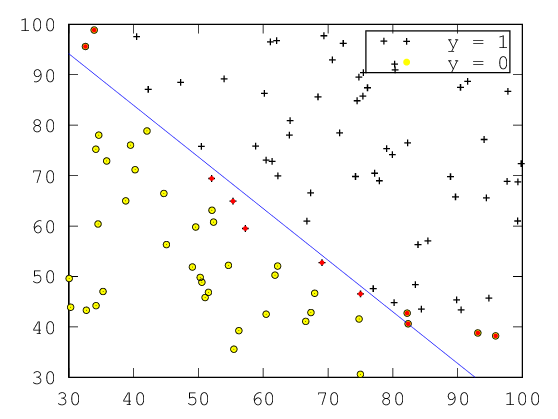

In [26]:
plotDecisionBoundary(theta, X, y);

hold on;
mistakes = find((p == y) == 0);
for i = 1:size(mistakes, 1),
    j = mistakes(i);
    plot(X(j, 2), X(j, 3), 'r');
end;
hold off;

# Regularized logistic regression

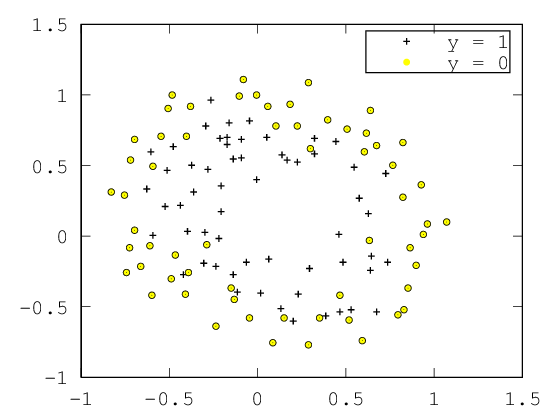

In [27]:
data = load('ex2data2.txt');
X = data(:, [1, 2]); y = data(:, 3);
plotData(X, y);

## Feature mapping

このデータセットだと直線で pos / neg を分割することはできない。
フィッティングさせるためにとれる方法の１つとして各データからより多くの feature を作るというのがある。

In [28]:
function out = mapFeature(X1, X2)
    degree = 6;
    out = ones(size(X1(:, 1)));
    for i = 1:degree,
        for j = 0:i,
            out(:, end + 1) = (X1.^(i-j)).*(X2.^j);
        end
    end
endfunction

In [29]:
x = mapFeature(X(:, 1), X(:, 2));
initial_theta = zeros(size(x, 2), 1);
lambda = 1;

### Cost function

$$
J(\theta) = {1 \over m}\sum_{i=1}^m[
-y^{(i)}log(h_\theta(x^{(i)}))
-(1-y^{(i)})log(1 - h_\theta(x^{(i)}))]
+{\lambda \over 2m}\sum_{j=1}^n\theta_j^2
]
$$

### Gradient

$$
\begin{eqnarray}
{\partial J(\theta) \over \partial \theta_0}
& = & {1 \over m}\sum_{i = 1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} & \ (for \  j = 0) \\
{\partial J(\theta) \over \partial \theta_j}
& = & ({1 \over m}\sum_{i = 1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)})
 + {\lambda \over m}\theta_j & \ (for\  j \ge 1)
 \end{eqnarray}
$$

In [30]:
function [J, grad] = costFunctionReg(theta, X, y, lambda)
    m = length(y);
    n = size(X, 2);
    J = 0;
    grad = zeros(size(theta));
    
    j1 = 0;
    j2 = 0;
    for i = 1:m,
        g = sigmoid(theta' * X(i, :)');

        % compute cost
        j1 = j1 + (-1 * y(i) * log(g) -1 * (1 - y(i)) * log(1 - g));
        % compute gradient
        grad = grad + X(i, :)' * (g - y(i));
    end
    
    % j = 1 つまり theta(1) は正規化しない
    for j = 2:n,
        j2 = j2 + theta(j) ^ 2;
    end
    
    J = j1 / m + lambda * j2 / (2 * m);
    % theta(1) は正規化しないので 0 として計算する
    grad = grad / m + [0; theta(2:size(theta))] * (lambda / m);
endfunction

% You should see that the cost is about 0.693
[cost, grad] = costFunctionReg(initial_theta, x, y, lambda);
cost

cost =  0.69315


### Learning parameters using `fminunc`

In [31]:
initial_theta = zeros(size(x, 2), 1);
lambda = 1;
options = optimset('GradObj', 'on', 'MaxIter', 400);

[theta, J, exit_flag] = fminunc(@(t)(costFunctionReg(t, x, y, lambda)), initial_theta, options);

Train Accuracy: 83.050847


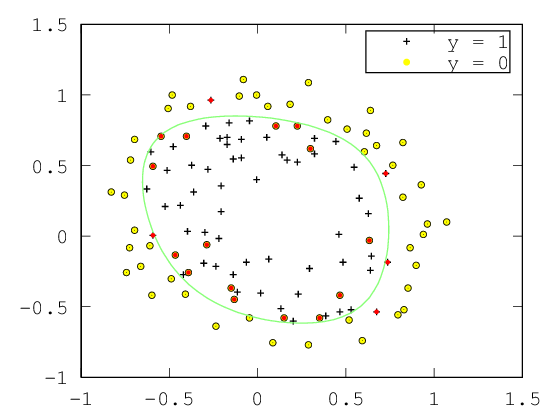

In [51]:
p = predict(theta, x);
fprintf('Train Accuracy: %f\n', mean(double(p == y)) * 100);

plotDecisionBoundary(theta, x, y);
hold on;

mistakes = find((p == y) == 0);
for i = 1:size(mistakes),
    j = mistakes(i);
    plot(x(j, 2), x(j, 3), 'r');
end
hold off;

### Overfitting

$\lambda = 0$

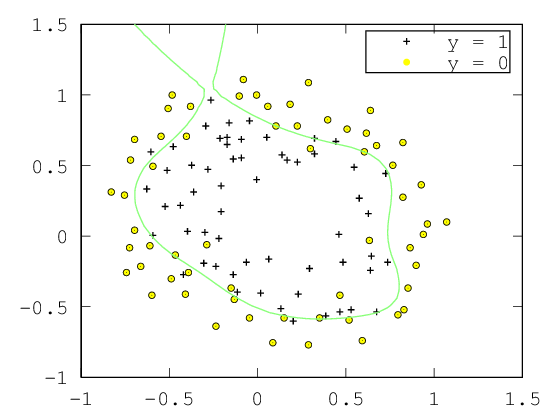

In [52]:
initial_theta = zeros(size(x, 2), 1);
lambda = 0;
options = optimset('GradObj', 'on', 'MaxIter', 400);

[theta, J, exit_flag] = fminunc(@(t)(costFunctionReg(t, x, y, lambda)), initial_theta, options);
plotDecisionBoundary(theta, x, y);

### Underfit

$\lambda = 100$

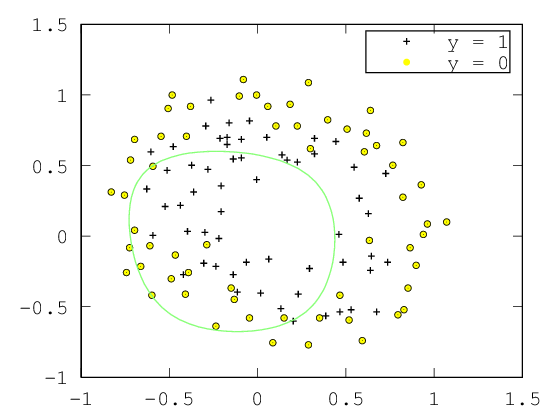

In [53]:
initial_theta = zeros(size(x, 2), 1);
lambda = 100;
options = optimset('GradObj', 'on', 'MaxIter', 400);

[theta, J, exit_flag] = fminunc(@(t)(costFunctionReg(t, x, y, lambda)), initial_theta, options);
plotDecisionBoundary(theta, x, y);